In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Data_Science_Projects/TCAV_Investigation

/content/drive/MyDrive/Data_Science_Projects/TCAV_Investigation


## TCAV



TCAV, or *Testing with Concept Activation Vectors*, is a well-known tool for interpreting deep learning models first proposed by Kim *et. al* [1]. TCAV is intended to test whether a model relies on human-understandable concepts in its hidden layers when those concepts aren't explicitly among the input features.

[1] https://arxiv.org/abs/1711.11279

For instance, in many tasks we don't want the model's reasoning about us to rely on race or gender (Kim *et. al* discuss image classification examples). Even if race or gender aren't found in the model inputs, though, our model might be "learning" them somewhere in its hidden layers, possibly leading to biased outputs.

An in-depth description of TCAV can be found in the original paper, but here's a broad overview of how the method checks whether concept *C* is important for a model's reasoning about output class *k* in dataset *X* at hidden layer *l*:

 1. Retrieve the activations from the class-*k* members of *X* at *l*.
 2. Fit a linear classifier that separates the activations based on whether they are from a *C* example or a non-*C* example.
 3. Define the Concept Activation Vector (CAV) for *C* as the unit vector orthogonal to the boundary hyperplane in the direction of *C*.
 4. Calculate gradients of the model outputs with respect to the layer *l* activations.
 5. Calculate directional derivatives of the gradients in the direction of *C* by taking the dot products of the gradients and the CAV. These are the *sensitivities* of the model outputs to concept *C* at layer *l*.
 6. Calculate the *TCAV score* of concept *C* at layer *l* by finding the proportion of the dataset with positive sensitivity.

TCAV scores range from 0 to 1. According to Kim *et. al*, a TCAV score away from 0.5 in ether direction indicates that "we can consider the resulting concept as related to the class prediction".

This project tries to gain a better understanding of how TCAV works. I give examples of the method failing to identify important concepts and identifying unimportant concepts. I conclude that TCAV score is a measure of the *directional uniformity* of a concept's effect on the model predictions.

### Implementation

I use TensorFlow to implement a basic TCAV class that performs every step listed above.

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.linear_model import SGDClassifier
import graphviz
import copy

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
class TCAV():
    def __init__(self, model, layer_idx=0, random_state=0):
        self.layer_activations = None
        self.cav = None

        self.model = model
        self.lm = SGDClassifier(penalty='l1', alpha=0.01, random_state=random_state)
        self._set_layer(layer_idx)
        self._set_submodels()

    def _set_layer(self, layer_idx):
        self.layer_idx = layer_idx
        self.layer = self.model.layers[layer_idx]

    def _set_submodels(self):
        # Submodel taking inputs to layer activations
        self.model_f = tf.keras.Model(inputs=self.model.input,
                                      outputs=self.model.layers[self.layer_idx].output)
        # Submodel taking layer activations to outputs
        model_h_input = copy.deepcopy(tf.keras.layers.Input(self.model.layers[self.layer_idx+1].input_shape[1:]))
        output = model_h_input
        for layer in self.model.layers[self.layer_idx + 1:]:
            output = copy.deepcopy(layer)(output)
        self.model_h = tf.keras.Model(inputs=model_h_input, outputs=output)

    def _set_layer_activations(self, X):
        self.layer_activations = tf.convert_to_tensor(self.model_f(X))

    def _set_gradients(self): # requires self.layer_activations
        with tf.GradientTape() as tape:
            tape.watch(self.layer_activations)
            y_hat = self.model_h(self.layer_activations)
        self.grad = tf.keras.backend.get_value(tape.gradient(y_hat, self.layer_activations))

    def _set_sensitivity(self, concept_labels, y, y_value): # requires self.cav
        self._set_gradients()
        self.sensitivity = np.dot(self.grad[y==y_value], self.cav)

    def train_cav(self, X, concept_labels):
        # Calculate hidden layer activations
        self._set_layer_activations(X)
        # Fit hidden layer activations
        self.lm.fit(self.layer_activations, concept_labels)
        self.cav = self.lm.coef_.T/np.linalg.norm(self.lm.coef_)
        return self.cav

    def get_layer_prediction_accuracy(self, X, concept_labels):
        # fit model
        if self.cav is None:
            self.train_cav(X, concept_labels)
        # return accuracy score
        return self.lm.score(self.layer_activations, concept_labels)

    def tcav_score(self, X, concept_labels, y, y_value):
        # fit model
        if self.cav is None:
            self.train_cav(X, concept_labels)
        # calculate input sensitivities
        self._set_sensitivity(concept_labels, y, y_value)
        # return TCAV score
        tcav_score = (self.sensitivity > 0).sum()/(y == y_value).sum()
        return tcav_score

## Model

To investigate TCAV, I'll see how it works on a relatively simple example in which we're able to know exactly how different concepts affect the model's reasoning. To this end, I define a "dataset" that contains 3 Boolean features A, B, and C and a $y$ variable representing (A XOR B) XOR C.

In [5]:
df = pd.DataFrame({'A': [1,0,1,0,1,0,1,0],
                   'B': [1,1,0,0,1,1,0,0],
                   'C': [1,1,1,1,0,0,0,0],
                   'A OR B': [1,1,1,0,1,1,1,0],
                   '~(A AND B)': [0,1,1,1,0,1,1,1],
                   'A XOR B': [0,1,1,0,0,1,1,0],
                   '(A XOR B) XOR C': [1,0,0,1,0,1,1,0]},
                  index=range(1,9))

input_columns = ['A', 'B', 'C']
X = tf.Variable(df[input_columns].values, dtype=tf.float64)
y = df['(A XOR B) XOR C'].values

XOR problems are interesting because the target classes aren't linearly separable. Solving them with neural networks requires hidden layers. The diagram below shows a solution for a 2-input XOR problem that takes advantage of the fact that A XOR B is logically equivalent to (A OR B) AND ~(A AND B). Each gate contains an activation function that goes to 1 given positive input and 0 otherwise.

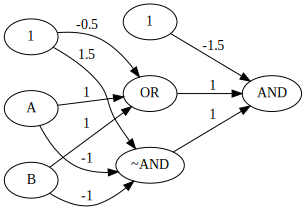

In [6]:
graphviz.Source.from_file('graphs/saved_graphs/network1.gv')

In [7]:
df.loc[:4, ['A','B','A OR B','~(A AND B)','A XOR B']]

,A,B,A OR B,~(A AND B),A XOR B
1,1,1,1,0,0
2,0,1,1,1,1
3,1,0,1,1,1
4,0,0,0,1,0


To solve the 3-input XOR problem ((A XOR B) XOR C), we can embed the A XOR B architecture inside a network that takes its output and XORs it with C.

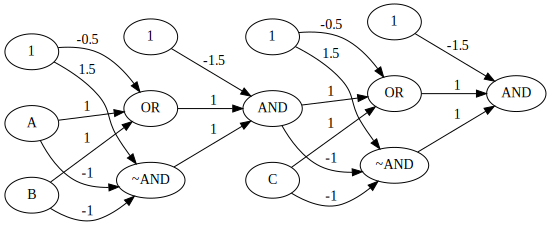

In [8]:
graphviz.Source.from_file('graphs/saved_graphs/network2.gv')

In [9]:
df

,A,B,C,A OR B,~(A AND B),A XOR B,(A XOR B) XOR C
1,1,1,1,1,0,0,1
2,0,1,1,1,1,1,0
3,1,0,1,1,1,1,0
4,0,0,1,0,1,0,1
5,1,1,0,1,0,0,0
6,0,1,0,1,1,1,1
7,1,0,0,1,1,1,1
8,0,0,0,0,1,0,0


If my implementation of the network actually used the flat stepwise activation function describe above, the gradients would all be 0. To closely simulate this function while maintaining meaningful gradients, I use a compressed sigmoid as the activation function at each layer.

In [10]:
def layer_activation(x):
    return tf.nn.sigmoid(10*x)

My implementation feeds all three features to the input layer, keeping the "C" values isolated until they're fed into Hidden Layer 3. These are the network weights we'll need:


In [11]:
weights1 = tf.Variable(np.array([[1,-1,0],[1,-1,0],[0,0,2]]), dtype=tf.float64)
bias1 = tf.Variable(np.array([-0.5,1.5,-1]), dtype=tf.float64)

weights2 = tf.Variable(np.array([[1,0],[1,0],[0,2]]), dtype=tf.float64)
bias2 = tf.Variable(np.array([-1.5,-1]), dtype=tf.float64)

weights3 = tf.Variable(np.array([[1,-1],[1,-1]]), dtype=tf.float64)
bias3 = tf.Variable(np.array([-0.5,1.5]), dtype=tf.float64)

weights4 = tf.Variable(np.array([[1],[1]]), dtype=tf.float64)
bias4 = tf.Variable(np.array([-1.5]), dtype=tf.float64)

I define the model and confirm that it works.

In [12]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(3, activation=layer_activation, weights=[weights1,bias1], name='hidden1'),
        tf.keras.layers.Dense(2, activation=layer_activation, weights=[weights2,bias2], name='hidden2'),
        tf.keras.layers.Dense(2, activation=layer_activation, weights=[weights3,bias3], name='hidden3'),
        tf.keras.layers.Dense(1, activation=layer_activation, weights=[weights4,bias4], name='output'),
    ],
    name='my_sequential'
    )

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [14]:
model(X)

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[0.9923533 ],
       [0.0071906 ],
       [0.0071906 ],
       [0.9923533 ],
       [0.00718809],
       [0.992353  ],
       [0.992353  ],
       [0.00718809]], dtype=float32)>

In [15]:
model.evaluate(X, y)

1/1 [==============================] - 0s 336ms/step - loss: 0.0074 - accuracy: 1.0000


[0.007445765659213066, 1.0]

The network correctly classifies each example with low cross-entropy loss.

## Testing Concepts



### A OR B

An advantage of using a simple, hard-coded model is that we know exactly where certain concepts are represented in the model and how the model uses those concepts in its reasoning. I'll first look at the case of A OR B.

In [16]:
concept = 'A OR B'
concept_labels = df[concept].values

The model represents A OR B in the first neuron of Hidden Layer 1, as we can see below. It then applies an AND operation to conjoin the concept with ~(A AND B).

In [17]:
tcav = TCAV(model, layer_idx=0)
tcav.train_cav(X, concept_labels)
print('Hidden Layer 1 Activations:')
print(tcav.layer_activations)

Hidden Layer 1 Activations:
tf.Tensor(
[[9.999997e-01 6.692851e-03 9.999546e-01]
 [9.933072e-01 9.933072e-01 9.999546e-01]
 [9.933072e-01 9.933072e-01 9.999546e-01]
 [6.692851e-03 9.999997e-01 9.999546e-01]
 [9.999997e-01 6.692851e-03 4.539787e-05]
 [9.933072e-01 9.933072e-01 4.539787e-05]
 [9.933072e-01 9.933072e-01 4.539787e-05]
 [6.692851e-03 9.999997e-01 4.539787e-05]], shape=(8, 3), dtype=float32)


A linear classifier fit to these activations is of course able to perfectly distinguish A OR B examples from ~(A OR B) examples.

In [18]:
acc = tcav.get_layer_prediction_accuracy(X, concept_labels)
print('Prediction Accuracy:', acc)

Prediction Accuracy: 1.0


The CAV is defined as the coefficients of the linear classifier. It is roughly in the direction of A OR B in the activation space, though it gets a bit distracted by the second dimension and the imperfect activation function.

In [19]:
print('CAV:')
print(tcav.cav)

CAV:
[[ 0.91887672]
 [-0.39454476]
 [ 0.        ]]


We know that the A OR B concept is important at this layer for the model's predictions. We'll check whether this is reflected in the TCAV score and sensitivities for the $y = 1$ class. Note that this gives the sensitivities for rows 1, 4, 6, and 7.

In [20]:
df.loc[[1,4,6,7]]

,A,B,C,A OR B,~(A AND B),A XOR B,(A XOR B) XOR C
1,1,1,1,1,0,0,1
4,0,0,1,0,1,0,1
6,0,1,0,1,1,1,1
7,1,0,0,1,1,1,1


In [21]:
tcav_score = tcav.tcav_score(X, concept_labels, y, 1)
print('TCAV Score:', tcav_score)

TCAV Score: 0.5


In [22]:
print('Sensitivity:')
tcav.sensitivity

Sensitivity:


array([[-2.63639714e-05],
       [-2.63639714e-05],
       [ 3.01125423e-05],
       [ 3.01125423e-05]])

The sensitivity values are negative for rows 1 and 4 but positive for rows 6 and 7, so the TCAV score is 0.5. TCAV fails to flag A OR B as an important concept at this layer even though it clearly is; why is this the case?

For the first and second $y=1$ examples (rows 1 and 4 of the entire dataset), moving in the A OR B direction in Hidden Layer 1 means moving in the A XOR B direction in Hidden Layer 2. Since C = 1 in those rows, a move in the A XOR B direction is a move *away from* (A XOR B) XOR C, so the sensitivity values are negative.

In [23]:
df.loc[[1,4]]

,A,B,C,A OR B,~(A AND B),A XOR B,(A XOR B) XOR C
1,1,1,1,1,0,0,1
4,0,0,1,0,1,0,1


For the third and fourth $y=1$ examples (rows 6 and 7 of the entire dataset), moving in the A OR B direction in Hidden Layer 1 again means moving in the A XOR B direction in Hidden Layer 2. However, since C = 0 in those rows, a move in the A XOR B direction is a move *towards* the (A XOR B) XOR C direction, so the sensitivity values are positive.

In [24]:
df.loc[[6,7]]

,A,B,C,A OR B,~(A AND B),A XOR B,(A XOR B) XOR C
6,0,1,0,1,1,1,1
7,1,0,0,1,1,1,1


### A XOR B

We'll look at another example before moving on. A XOR B is an important concept in Hidden Layer 2. It's represented in the layer's first neuron, and the next two layers XOR it with C to give the final output.

In [25]:
concept = 'A XOR B'
concept_labels = df[concept].values

In [26]:
tcav = TCAV(model, layer_idx=1)
tcav.train_cav(X, concept_labels)
print('Hidden Layer 2 Activations:')
print(tcav.layer_activations)

Hidden Layer 2 Activations:
tf.Tensor(
[[7.1527860e-03 9.9995458e-01]
 [9.9235588e-01 9.9995458e-01]
 [9.9235588e-01 9.9995458e-01]
 [7.1527860e-03 9.9995458e-01]
 [7.1527860e-03 4.5439105e-05]
 [9.9235588e-01 4.5439105e-05]
 [9.9235588e-01 4.5439105e-05]
 [7.1527860e-03 4.5439105e-05]], shape=(8, 2), dtype=float32)


Again, a linear classifier fit to these activations of course has perfect accuracy.

In [27]:
acc = tcav.get_layer_prediction_accuracy(X, concept_labels)
print('Prediction Accuracy:', acc)

Prediction Accuracy: 1.0


The CAV is in the direction of A XOR B in the activation space.

In [28]:
print('CAV:')
print(tcav.cav)

CAV:
[[1.]
 [0.]]


We know that the A XOR B concept is important at Hidden Layer 2 for the model's predictions. We'll again check whether this is reflected in the TCAV score and sensitivities for the $y = 1$ class.

In [29]:
tcav_score = tcav.tcav_score(X, concept_labels, y, 1)
print('TCAV Score:', tcav_score)

TCAV Score: 0.5


In [30]:
print('Sensitivity:')
tcav.sensitivity

Sensitivity:


array([[-0.00070802],
       [-0.00070802],
       [ 0.00075709],
       [ 0.00075709]])

We again find a TCAV score of 0.5 for this clearly important concept. For the row 1 and 4 examples, moving in the A XOR B direction means moving *away from* the (A XOR B) XOR C direction since C = 1. For the row 6 and 7 examples, moving in the A XOR B direction means moving *towards* the (A XOR B) XOR C direction since C = 0.  

## Discussion

According to Kim *et. al*, TCAV score "uses directional derivatives to quantify the degree to which a user-defined concept is important to a classification result" (*ibid.* p. 1). After working through these examples, I think this claim needs some qualification.

TCAV score only measures a particular type of importance: the *directional consistency* of a concept's impact on class predictions at a given layer. An extreme TCAV score (towards either 0 or 1) arises when moving in the direction of a concept generally has the same type of effect on class predictions across the dataset. For instance, Kim *et. al* show that the concept RED gets a high TCAV score across most layers of a CNN trained to classify FIRE ENGINE images. This result is expected since (at least to my knowledge) RED has a pretty straightforward positive relationship with FIRE ENGINE.

TCAV score struggles to capture the importance of concepts with a more complex impact on model predictions. In the above example, A OR B is clearly an important concept for the model's predictions of the $y=1$ class. One neuron recreates it (nearly) exactly, and for rows 4, 6, and 7, flipping its value in that layer flips the prediction. However, the concept's importance isn't captured by the TCAV score because its effect is inconsistent, varying due to interactions with other concepts. Moving in the A OR B direction has a positive effect on the model's prediction if C = 0 and a negative effect if C = 1.